# Machine learning lab #1 (kNN)

### Andosov German, M33391

##### Part 5. Using LOWESS to indicate anomalies

In [8]:
%run "02-algorithm.ipynb"

from IPython.display import clear_output

clear_output(wait=False)

<details>
  <summary><i>Secret knowledge</i></summary>
  <img src="lowess.png" width="1000" height="400"></img>
</details>

Finding "anomalies":

In [9]:
counter = 0
success = 0
normal, anomalies1, anomalies2 = [], [], []

for x_id in X_train.index:
    prediction = KNN(
        window_param=82,
        window_type=WindowType.VARIABLE,
        kernel=Kernel.TRIANGULAR,
        metric=Metric.MANHATTAN,
    ).fit(X_train.drop(index=x_id), y_train.drop(index=x_id), default_weights).predict(X_train.loc[[x_id]])[0]
    counter += 1
    if counter % 1000 == 0:
        print(counter, "done")
    true_class = y_train.loc[x_id]
    if true_class == prediction:
        normal.append(counter - 1)
    elif abs(true_class - prediction) == 1:
        anomalies1.append(counter - 1)
    else:
        anomalies2.append(counter - 1)

print("Accuracy", len(normal) / counter * 100)
print("Anomalies of 1st type:", len(anomalies1))
print("Anomalies of 2nd type:", len(anomalies2))

1000 done
2000 done
3000 done
4000 done
5000 done
6000 done
7000 done
8000 done
9000 done
10000 done
Accuracy 85.11790072483714
Anomalies of 1st type: 1611
Anomalies of 2nd type: 11


It's rational to skip anomalies of 2nd type, so the only question is – what is the weight for anomalies of 1st type.

Text(0, 0.5, 'Accuracy')

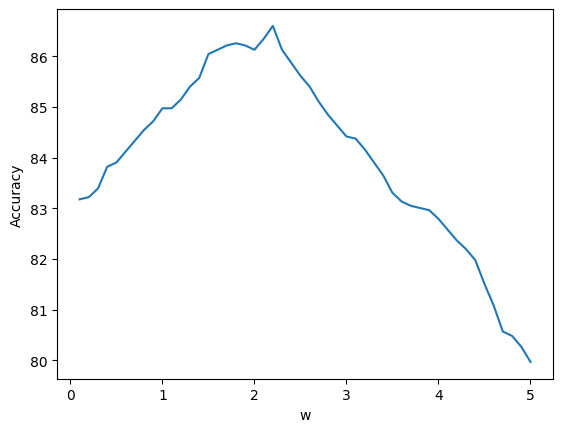

In [10]:
def get_new_weights(w):
    new_weights = []
    for i in range(len(X_train)):
        if i in anomalies1:
            new_weights.append(w)
        elif i in anomalies2:
            new_weights.append(0)
        else:
            new_weights.append(1)
    return new_weights


def get_accuracy(w, X, y):
    my_knn = KNN(
        window_param=82,
        window_type=WindowType.VARIABLE,
        kernel=Kernel.TRIANGULAR,
        metric=Metric.MANHATTAN,
    )
    predictions = my_knn.fit(X_train, y_train, get_new_weights(w)).predict(X)
    return accuracy(y.to_list(), predictions)


xs = [x / 10 for x in range(1, 51)]
ys = [get_accuracy(w, X_test, y_test) for w in xs]
plt.plot(xs, ys)
plt.xlabel('w')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

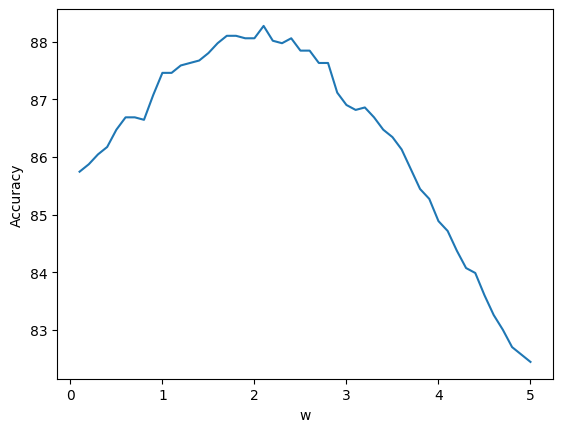

In [11]:
ys = [get_accuracy(w, X_val, y_val) for w in xs]
plt.plot(xs, ys)
plt.xlabel('w')
plt.ylabel('Accuracy')

well, seems like in our dataset anomalies are close points?

let's do check the library implementation – we will add extra object for all 1st type anomalies (sampling)

In [12]:
def get_lib_accuracy(X, y, X_t, y_t):
    lib_knn = KNeighborsClassifier(n_neighbors=24, weights='uniform', algorithm='ball_tree', p=2.5)
    predictions = lib_knn.fit(X, y).predict(X_t)
    return accuracy(y_t.to_list(), predictions)


X_an, y_an = X_train.iloc[anomalies1], y_train.iloc[anomalies1]
X_train_sampled, y_train_sampled = pd.concat([X_train, X_an]), pd.concat([y_train, y_an])

print("Old accuracy", get_lib_accuracy(X_train, y_train, X_test, y_test))
print("New accuracy", get_lib_accuracy(X_train_sampled, y_train_sampled, X_test, y_test))

Old accuracy 83.04794520547945
New accuracy 83.09075342465754
